# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats.distributions as dist
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


><span style="color:red">Response: The above cell displays the first 5 rows of the data set.</span>

**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
print(len(df))

294478


><span style="color:red">Response: There are 294,478 rows in the dataset.</span>

**c.** The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

><span style="color:red">Response: There are 290,584 unique users in the dataset.</span>

**d.** The proportion of users converted.

In [5]:
df.groupby(['converted']).agg({'timestamp':'count'})

,timestamp
converted,
0,259241
1,35237


In [6]:
df[df['converted'] == 1].shape[0]/df.shape[0]

0.11965919355605512

><span style="color:red">Response: The proportion of users converted is 0.11965919355605512. That is, roughly 12% of the entire population was converted.</span>

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df.groupby(['group','landing_page']).agg({'timestamp':'count'})

timestamp
group     landing_page           
control   new_page           1928
          old_page         145274
treatment new_page         145311
          old_page           1965

><span style="color:red">Response: There were 1,965 times where the "group" = treatment and "landing_page" is <i>not</i> new_page (old_page).</span>

**f.** Do any of the rows have missing values?

In [8]:
df.isnull().values.any()

False

><span style="color:red">Response: There are no rows missing values: e.g., null values.</span>

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df3=df[df['landing_page'].eq('new_page')&df['group'].eq('control')]
df4=df[df['landing_page'].eq('old_page')&df['group'].eq('treatment')]
df2=df

print(len(df), len(df2), len(df3),len(df4))

294478 294478 1928 1965


><span style="color:red">Response: In the above cell, I created two dataframes to "hold" the incorrect entries (df3,df4) and the new dataframe for our "clean" dataset </span>

In [10]:
#df2.drop(df4.index, inplace=True)
df2.drop(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].index, inplace=True)
df2.drop(df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].index, inplace=True)

print(len(df), len(df2), len(df3),len(df4))

290585 290585 1928 1965


><span style="color:red">Response: From the new dataframe df2 I removed those entries that matched our conditions; then, I compared the number of rows between all dataframes</span> 

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
tn = df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]
co = df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]
print(tn,co)

0 0


><span style="color:red">Response: The above cell shows that no rows have the treatment/new_page (tn) or control/old_page (co) attributes within our new dataframe df2.</span>
    
### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [12]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

><span style="color:red">Response: there are 290,584 unique user_ids in df2.</span>

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2Dup=df2[df2.duplicated(['user_id'],keep=False)]
df2Dup['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

><span style="color:red">Response: The above cell displays which entries are duplicated within the dataframe. user_id 773192 is duplicated.</span>

**c.** Display the rows for the duplicate **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


><span style="color:red">Response: The above cell shows the <i>second</i> instance that user_id 773192 appears; this coincides with the values found in the cell above that.</span>

**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop([2893],inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2.duplicated('user_id').sum()

0

><span style="color:red">Response: The duplicated cell was removed by specifying its index to be dropped. Then confirmed that there were no duplicate rows.</span>

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

><span style="color:red">Response: The probability of an individual being converted is 0.11959708724499628, or a ~12% probability.

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_group = len(df2.query('group == "control" and converted == 1'))/len(df2.query('group=="control"'))
control_group

0.1203863045004612

><span style="color:red">Response: There is a 0.1203863045004612 or ~12% probability that an individual was in the "control" group AND converted.</span>

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_group = len(df2.query('group == "treatment" and converted == 1'))/len(df2.query('group=="treatment"'))
treatment_group

0.11880806551510564

><span style="color:red">Response: The probability that an individual was in the "treatment" group AND converted is 0.11880806551510564 or ~12%.</span>

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff = treatment_group - control_group
obs_diff

-0.0015782389853555567

><span style="color:red">Response: This value shows that the difference between the control and treatment groups is -0.0015782389853555567 -- that is, the conversion rate is <i>less</i> in the new treatment group.

**d.** What is the probability that an individual received the new page?

In [20]:
len(df2.query('landing_page == "new_page"'))/len(df2.index)

0.5000619442226688

><span style="color:red">Response: The probability an individual would receive a new page is 0.5000619442226688 or ~50%.

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

><span style="color:red">Response: Considering the results from above, the new treatment group did NOT lead to more conversions. For the control group, the conversion rate was 0.1203863045004612; for the treatment group, the conversion rate was 0.11880806551510564. The difference between these two of -0.0015782389853555567, with a slightly less conversion rate for the treatment group.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

><span style="color:red">Response: My null hypothesis H<sub>0</sub> is that the new page p<sub>new</sub> isn't any better than the old page p<sub>old</sub> at converting visitors. The alternative hypothesis, H<sub>1</sub>, would have a Type I error that the new page <b>IS</b> better than the old page

<span style="color:red"><center>H<sub>0</sub>: p<sub>new</sub> - p<sub>old</sub> <= 0</center></span>
    <span style="color:red"><center>(That is, the difference between the new and old page is zero or negative in conversion rates)</center></span>

<span style="color:red"><center>H<sub>1</sub>: p<sub>new</sub> - p<sub>old</sub> > 0</center></span>
    <span style="color:red"><center>(That is, the difference between the new and old is in favor of the new page)</center></span>

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = len(df2.query('converted == 1'))/len(df2.index)
p_new

0.11959708724499628

><span style="color:red">Response: The conversion rate of the new page is 0.11959708724499628; under the null hypothesis H<sub>0</sub>, the same as the old page, so it should match the following answer.

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = len(df2.query('converted == 1'))/len(df2.index)
p_old

0.11959708724499628

><span style="color:red">Response: The conversion rate of the old page is also 0.11959708724499628; under the null hypothesis H<sub>0</sub>, the same as the new page, so it should match the previous answer.

**c.** What is $n_{new}$, the number of individuals in the treatment group? 

In [23]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

><span style="color:red">Response: There are 145,
    310 individuals in the treatment group.

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

><span style="color:red">Response: There are 145,274 individuals in the control group.

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.

In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

><span style="color:red">Response: The new_page_converted array has randomly created n<sub>new</sub> of values using the p<sub>new</sub> number conversion rate calculated earlier in 2.2a.
    
**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

><span style="color:red">Response: The old_page_converted array has randomly created n<sub>old</sub> of values using the p<sub>old</sub> conversion rate calculated earlier in 2.2b.
    
**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
# THESE ARE SIMULATED DATA
simul_diff = new_page_converted.mean() - old_page_converted.mean()
# differences computed in from p_new and p_old
simul_diff

0.0011791554321305409

><span style="color:red">Response: The simulated samples have a "conversion rate" (p'<sub>new</sub> - p'<sub>old</sub>) of -0.0007823613406847674 or ~ -0.07%.
    
**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    
    # 1st parameter dictates the choices you want.  In this case [1, 0]
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


><span style="color:red">Response: A new array p_diffs iterates through: 1) randomly generating p'<sub>new</sub> and p'<sub>old</sub>; 2) adds the difference between p'<sub>new</sub> - p'<sub>old</sub> to the p_diffs array. This is done 10,000 times.
    
**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

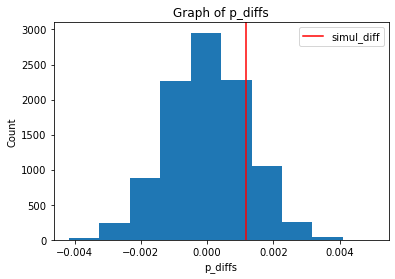

In [29]:
p_diffs=np.array(p_diffs)
#histogram of p_diff
plt.hist(p_diffs);

plt.title('Graph of p_diffs') #title of graphs
plt.xlabel('p_diffs') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

plt.axvline(x= simul_diff, color='r', label='simul_diff')
plt.legend();

><span style="color:red">Response: The above cell shows that the simulated difference (simul_diff) is very close to the p_diff values in the middle of the histogram, but shifted to the left (in the negative direction) where simul_diff = -0.0007823613406847674
    
**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [30]:
new_obs = df2[df2['landing_page'] == 'new_page']
new_obs = new_obs['converted'].mean()

old_obs = df2[df2['landing_page'] == 'old_page']
old_obs = old_obs['converted'].mean()
actual_diff = new_obs-old_obs
count = 0
for i in p_diffs:
    if i> actual_diff:
        count = count+1
        
pval=(p_diffs > actual_diff).mean()
pval

0.91

><span style="color:red">Response: The proportion of the p_diffs that are greater than the actual difference observed (actual_diff) in df2 data is 0.9076 or ~90.8% (the p-value).

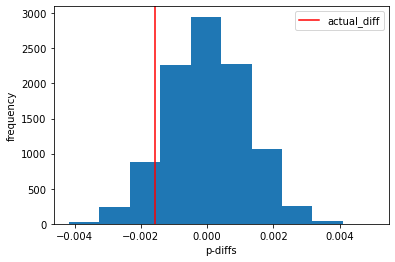

In [31]:
plt.hist(p_diffs)
plt.axvline(x=actual_diff,color='red',label='actual_diff')
plt.xlabel('p-diffs')
plt.ylabel('frequency')
plt.legend();

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

><span style="color:red">Response: This new value above is the "p-value", which is used to accept or reject the null hypothesis: if this value is greater than the expected p-value, we accept the null value. Our Type I error threshold α is 0.05.

> <span style="color:red">The calculated p-value (0.9076) is much larger than our error threshold α of 0.05, not less than or equal to. The null hypothesis cannot be rejected.</span> 

<span style="color:red"><center>pval ≤ α ⇒ Reject H<sub>0</sub></span>

<span style="color:red"><center>pval > α ⇒ pval > α ⇒ Fail to Reject H<sub>0</sub></span>

In [32]:
(actual_diff, simul_diff)

(-0.0015782389853555567, 0.0011791554321305409)



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" & converted == 1').shape[0]
convert_new = df2.query('group == "treatment" & converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old, convert_new

(17489, 17264)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

In [34]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative = 'larger')

print(z_score, p_value)

1.3109241984234394 0.09494168724097551


><span style="color:red">Response: My current alternate hypothesis H<sub>1</sub>: p<sub>new</sub> - p<sub>old</sub> can be written as p<sub>new</sub> > p<sub>old</sub>, so the 'larger', right-tailed alternative was used 
    
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [35]:
p_new, p_old, z_score, p_value

(0.11959708724499628,
 0.11959708724499628,
 1.3109241984234394,
 0.09494168724097551)

In [36]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.9050583127590245

In [37]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

><span style="color:red">Response: My null hypothesis H<sub>0</sub> is that the new page p<sub>new</sub> isn't any better than the old page p<sub>old</sub> at converting visitors. The alternative hypothesis, H<sub>1</sub>, would have a Type I error that the new page <b>IS</b> better than the old page

<span style="color:red"><center>H<sub>0</sub>: p<sub>new</sub> - p<sub>old</sub> <= 0</center>

<span style="color:red"><center>H<sub>1</sub>: p<sub>new</sub> - p<sub>old</sub> > 0</center>
    
><span style="color:red">The p-value (0.9050583127590245) is much larger than our error threshold α of 0.05, not less than or equal to. 
    
><span style="color:red">For a right-tailed z-test:

<center>$Z_{score}$ <= $Z_{\alpha}$ ⇒ Fail to Reject H<sub>0</sub>

<center>$Z_{score}$ > $Z_{\alpha}$ ⇒ Reject H<sub>0</sub>

><span style="color:red">The z-score $Z_{score}$ 1.3109241984234394 is the standard deviation units that the estimate falls from the null hypothesis and is less than the critical value $Z_{\alpha}$ (1.6448536269514722) at 95% confidence; this aligns with our previous fail-to-reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

><span style="color:red">Response: Since our dependent variable is binary (that is, conversion or no conversion) the type we should perform is a logistic regression.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [38]:
# Getting dummies:
pt3_df2 = df2

# add the intercept = 1 column
pt3_df2['intercept'] = 1

#add ab_page column, based on new_pag
pt3_df2[['control' ,'ab_page']] = pd.get_dummies(pt3_df2['group'])

pt3_df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


><span style="color:red">Response: A new dataframe pt3_df2 for logistic regression was created with two new columns "intercept" and "ab_page" prepopulated with a set value of 1 and dummy variables based on "group", respectively

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [39]:
import statsmodels.formula.api as sm

# Initializing and fitting the model:
model1 = sm.logit(data = pt3_df2, formula = "converted ~ 1 + ab_page")
results1 = model1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


><span style="color:red">Response: The data was modeled in a new variable called model1.

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
# Getting the model summary:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 20 Mar 2023   Pseudo R-squ.:               8.077e-06
Time:                        10:11:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

><span style="color:red">Response: The summary of the model was displayed from the results1 from model1.
    
**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  
><span style="color:red">Response: The p-value in the above summary is the 'LLR p-value': 0.190 -- which is much larger than our error threshold α of 0.05, not less than or equal to.

> pval ≤ α ⇒ Reject H0

> pval > α ⇒ pval > α ⇒ Fail to Reject H0

><span style="color:red">In <b>Part II</b>, the p-value represented the probability our null hypothesis is true. Currently, the p-value for <b>Part III</b> represents the probability that the values in our 2-tailed test from the sample set happened by chance. That is, whether the page performed differently than the old page (in either a positive or negative direction) in terms of conversion rate.</span>


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?<br><br>

> <span style="color:red">Response: Each regression model has their own flaws, so supplementing with other types of analysis is always a good idea. However, adding too many techniques can prove to be redundant -- especially if they produce the same answer -- as well as unnecessarily complicated and difficult to interpret. 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [41]:
# Read the countries.csv
# Inner join with the df2 dataframe
df_countries = pd.read_csv('countries.csv').set_index('user_id').join(pt3_df2.set_index('user_id'), how = 'inner')
df_countries.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


><span style="color:red">Response: Read the new file into new dataframe df_countries, inner joining on common "user_id" index.

In [42]:
df_countries[['UK','US','CA']] = pd.get_dummies(df_countries['country'])
df_countries.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,UK,US,CA
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [43]:
model2 = sm.logit(data = df_countries, formula = "converted ~ 1 + UK + CA")
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Mar 2023   Pseudo R-squ.:               1.521e-05
Time:                        10:11:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
UK            -0.0507      0.028     -1.786      0.074      -0.106       0.005
CA            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

><span style="color:red">Response: Some new dummy variables were created using "get_dummies" instead of using random() into a new dataframe df_countries. A quick look at the fitted data can be summarized from results2, seen above.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [61]:
# Create the necessary additional columns
df_countries['CA_ab_page'] = df_countries['CA'] * df_countries['ab_page']
df_countries['UK_ab_page'] = df_countries['UK'] * df_countries['ab_page']
df_countries['US_ab_page'] = df_countries['US'] * df_countries['ab_page']
df_countries.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,UK,US,CA,CA_ab_page,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,0,1


In [62]:
df_countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [68]:
d1 = df_countries['converted']
#f1 = df_countries[['intercept','ab_page','UK','CA']]
#f1 = "converted ~ 1 + ab_page + UK + CA + UK_ab_page + CA_ab_page"

model3 = sm.logit(data = df_countries, formula = "converted ~ 1 + UK_ab_page + CA_ab_page")
results3 = model3.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [ ]:
# Getting the model summary:
model2.summary()

><span style="color:red">Response: The p-values for either country (UK: 0.074; US: 0.129) and the landing page is still greater than our threshold of 0.05; we cannot reject the null hypothesis. 

><span style="color:red">These are just statistical values that cannot provide any other context about why we get these values or what affects conversion rate; as such, these two factors alone are not enough to definitely say that the conversion rate between the old and new pages are significantly different.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])